In [4]:
# Test script for classification
# Import packages

import numpy as np
import pandas as pd
import sys
import importlib
import matplotlib.pyplot as plt


# Good idea to add this folder to the json.settings file as "python.analysis.extraPaths".
sys.path.append('../functionScripts/')

import plotFunctions # totalCountsPlot, data_heatmap, correlation_plot
import analysisFunctions
import initFunctions as initf #import createDirs, debugReport, loadLightSheetData
import classifyFunctions
import helperFunctions

importlib.reload(initf)

# Set Paths to data and output
dirDict = dict()
rootDir = 'C:\OneDrive\KwanLab\Lightsheet_cFos_Pipeline\\'
dirDict['atlasDir'] = rootDir + 'Atlas\\'
dirDict['dataDir'] = rootDir + 'Data\\'
dirDict['B1'] =       dirDict['dataDir'] + 'lightSheetV1\\'
dirDict['B2'] =       dirDict['dataDir'] + 'lightSheetV2Rev\\'   #3/6/23 - Looking at the new, Realigned batch 2 data. #Realigned
dirDict['B2_Orig'] =  dirDict['dataDir'] + 'lightSheetV2\\'
dirDict['B3'] =       dirDict['dataDir'] + 'lightSheetV3\\'      #3/6/23 - Batch 3 with MDMA
dirDict['outputFormat'] = 'svg'

batchSplit = False          # Splits drugs from the first batch of data, from the second, from the 3rd. Batch 1 is labeled with 'a' (aSAL, aKET, aPSI), Batch 3 (cKET, MDMA)
splitTag  = ['a', '', 'c']  # Appended the to beginning of data from the first batch (PSI, KET, SAL -> aPSI, KET, aSAL).
testSplit = False           # Splits an individual drug for the sake of examining self-similarity
oldBatch2 = False

debugOutputs = False        # Saves csvs at intervals
scalingFactor = True        # Applies 1/total_cells as a scaling factor per mouse.
debug_ROI = ['Dorsal nucleus raphe']
outputFormat = 'png'

switchDir = dict(testSplit=testSplit, batchSplit=batchSplit, splitTag=splitTag, oldBatch2=oldBatch2, debugOutputs=debugOutputs, scalingFactor=scalingFactor, debug_ROI=debug_ROI, outputFormat=outputFormat)

# Make directories, and add their strings to the directory dictionary.
dirDict = initf.createDirs(rootDir, switchDir, dirDict)

In [5]:
# Set Figure style
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 8
plt.rcParams['svg.fonttype'] = 'none'

loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


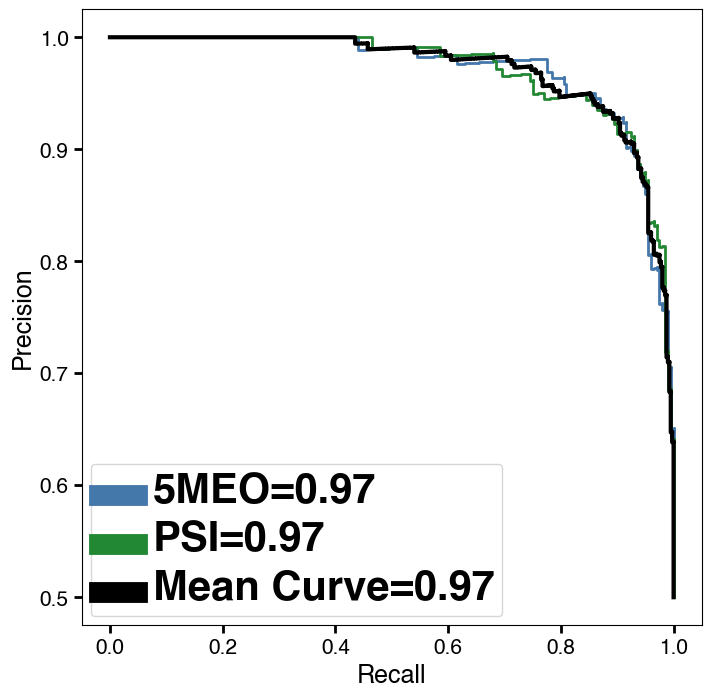

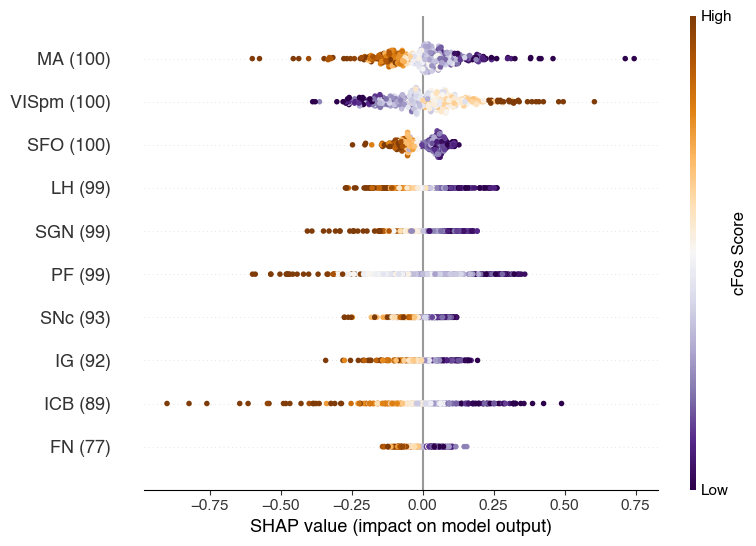

Real: 0.91 accuracy with a standard deviation of 0.16


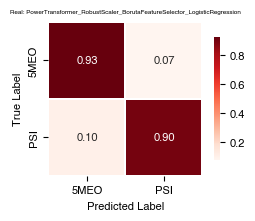

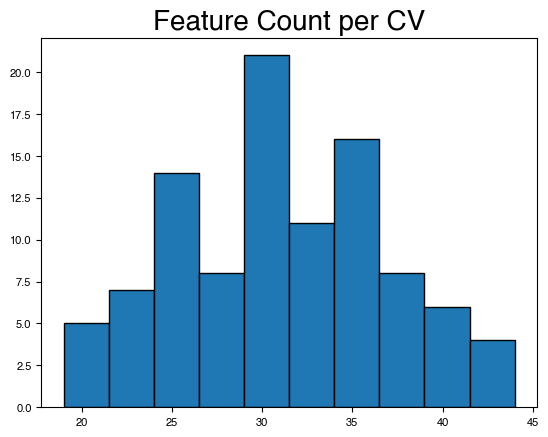

==== 5MEO vs PSI ==== 
 Features per Model: [25, 21, 41, 26, 36, 29, 30, 37, 22, 28, 19, 38, 35, 36, 37, 35, 25, 43, 29, 22, 34, 28, 29, 26, 38, 37, 25, 27, 30, 34, 36, 22, 32, 25, 34, 30, 37, 34, 25, 30, 31, 35, 44, 32, 35, 23, 31, 29, 30, 28, 25, 20, 33, 29, 31, 22, 26, 37, 44, 26, 26, 33, 31, 28, 30, 40, 23, 28, 31, 35, 41, 21, 32, 30, 30, 26, 28, 32, 41, 43, 39, 32, 27, 35, 30, 30, 29, 22, 33, 33, 38, 40, 35, 35, 25, 26, 32, 34, 19, 33]
Parameters: 
 
Total Regions = 158 
 Present 1x: 19 - LP, RCH, LC, EW, TMd, VMH, ARH, EPv, MOs, CENT, PYR, NLL, DT, ENTl, PR, POST, NB, CA2, GU
Present 2x: 27 - PCG, IF, AAA, RPA, SPVO, VISp, VISpor, VISpl, DR, CLA, AIp, ISN, AUDpo, ProS, PVH, PS, DN, RL, SCH, NI, BAC, SubG, RH, Xi, MPO, DMX, PG
Present 3x: 12 - ORBvl, VPL, ORBl, PAR, PGRNd, RM, RO, AUDp, PIL, PP, ACB, BLA
Present 4x: 6 - RT, AVPV, IPN, VII, PVa, SSp-n
Present 5x: 5 - SLC, MARN, SIM, IAD, SSp-un
Present 6x: 1 - SPFp
Present 7x: 8 - SG, AM, AT, IV, MT, PVi, PRE, PDTg
Present 8x: 8 - 

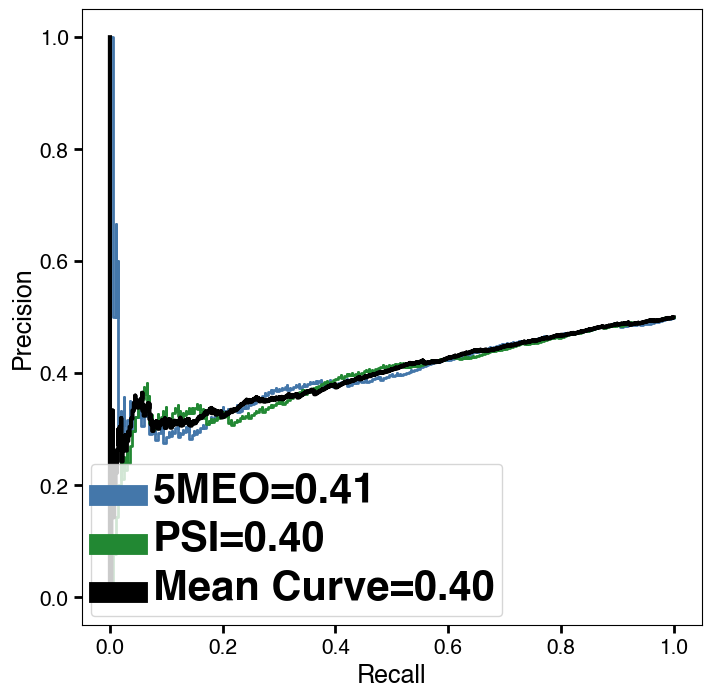

Shuffle: 0.36 accuracy with a standard deviation of 0.19


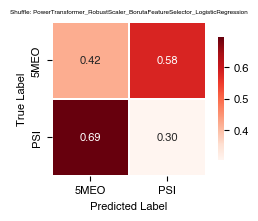

In [6]:
# Reload in case anything updated in these functions
importlib.reload(classifyFunctions)
importlib.reload(plotFunctions)
importlib.reload(helperFunctions)

color_dict = helperFunctions.create_color_dict('drug', True)

# Set a random seed for reproducibility.
np.random.seed(seed = 31415)

classifyDict = dict()

# Parameters for pivoting the data
classifyDict['data'] = 'count_norm' #cell_density, count, count_norm, density_norm
classifyDict['feature'] = 'abbreviation'
classifyDict['label'] = 'class_PsiDMT' # Defined in helperFunctions.create_drugClass_dict()
helperFunctions.create_drugClass_dict(classifyDict)

# Parameters for feature scaling and aggregation
classifyDict['featurefilt'] = False # True, False
classifyDict['filtType'] = 'min' # Min removes the bottom 1%, Max removes the top 99th percentile.
classifyDict['featureAgg'] = False
classifyDict['featureSel_linkage'] = 'average'  # 'average', 'complete', 'single', 'ward' (if euclidean)
classifyDict['featureSel_distance'] = 'correlation' # 'correlation, 'cosine', 'euclidean'
classifyDict['cluster_count'] = 100 # Number of clusters to generate. Not used at the moment.
classifyDict['cluster_thres'] = 0.2 # Anything closer than this is merged into a cluster
 
# Parameters for Preprocessing and feature selection
classifyDict['model_featureTransform'] = True # True, False
classifyDict['model_featureScale'] = True # True, False
classifyDict['model_featureSel'] = 'Boruta' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'
classifyDict['model_featureSel_alpha'] = 0.05 # Used for Fdr, Fwe, and Fwe_BH

# If Fdr/Fwe/None are not used for feature selection, the number of k feature must be preset
classifyDict['model_featureSel_mode'] = 'gridCV' # 'gridCV', 'modelPer'
# classifyDict['model_featureSel_k'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
classifyDict['model_featureSel_k'] = [30]

# Parameters for classification
classifyDict['model'] = 'LogRegL2' #'LogRegL2', 'LogRegL1', 'LogRegElastic', 'svm'
classifyDict['multiclass'] = 'multinomial' # 'ovr', 'multinomial'
classifyDict['max_iter'] = 100
classifyDict['CVstrat'] = 'ShuffleSplit' #'StratKFold', 'ShuffleSplit'

# ParamGrid Features - in instances where gridCV is set to true, these are the parameters that will be tested.
paramGrid = dict()
paramGrid['classif__l1_ratio'] = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]          # used for ElasticNet
# paramGrid['classif__C'] = [0.001, 0.01, 0.1, 1, 10]                    # used for LogisticRegression
paramGrid['classif__C'] = [1]                    # used for LogisticRegression
classifyDict['pGrid'] = paramGrid

classifyDict['shuffle'] = True
classifyDict['gridCV'] = False

if classifyDict['CVstrat'] == 'ShuffleSplit':
    classifyDict['CV_count'] = 100 # Number of folds for cross-validation
else:
    # K fold stratified can only afford n_classes of folds
    classifyDict['CV_count'] = 8

classifyDict['test_size'] = 1/4
classifyDict['innerFold'] = 4

classifyDict['saveLoadswitch'] = True

plotDict = dict()
plotDict['shapForcePlotCount'] = 0
plotDict['shapSummaryThres'] = 75   # Thres of CV inclusion for a feature to be plotted. Set to None to use shapMaxDisplay instead.
plotDict['shapMaxDisplay'] = 10     # Number of features to show in Shap Summary. Ignored if shapSummaryThres is not None.


# Load Pickle
lightsheet_data = pd.read_pickle('lightsheet_data.pkl') # lightsheet_data.pkl or lightsheet_all.pkl

# Pure visualizations
# plotFunctions.histPrePostScale(lightsheet_data, ['count', 'count_norm'], dirDict)

# plotFunctions.data_heatmap_block(lightsheet_data, 'abbreviation', 'count_norm', dirDict)

# plotFunctions.distance_matrix(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot_hier(lightsheet_data, classifyDict, dirDict)

# classifyDict['data'] = 'count_norm' #cell_density, count, count_norm, density_norm, count_norm_scaled
classifyFunctions.classifySamples(lightsheet_data, classifyDict, plotDict, dirDict)

Classifying class_PsiDMT
loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


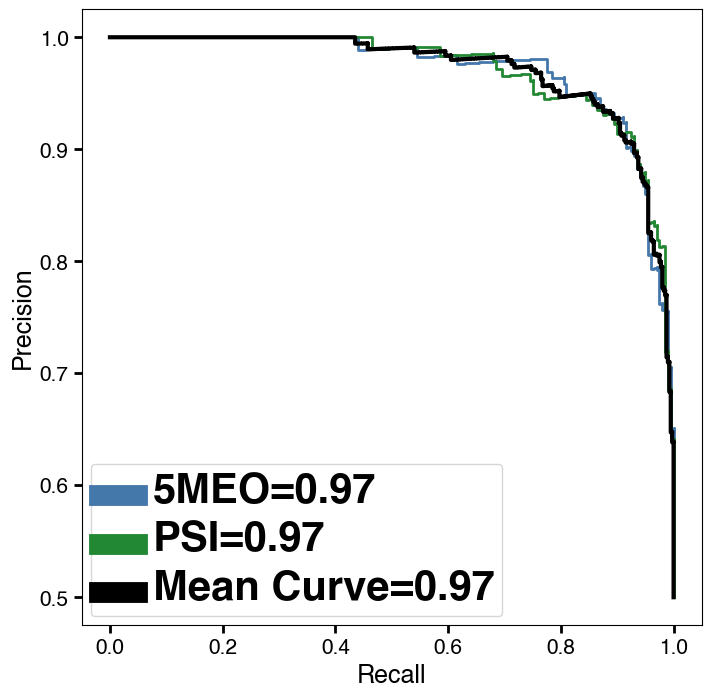

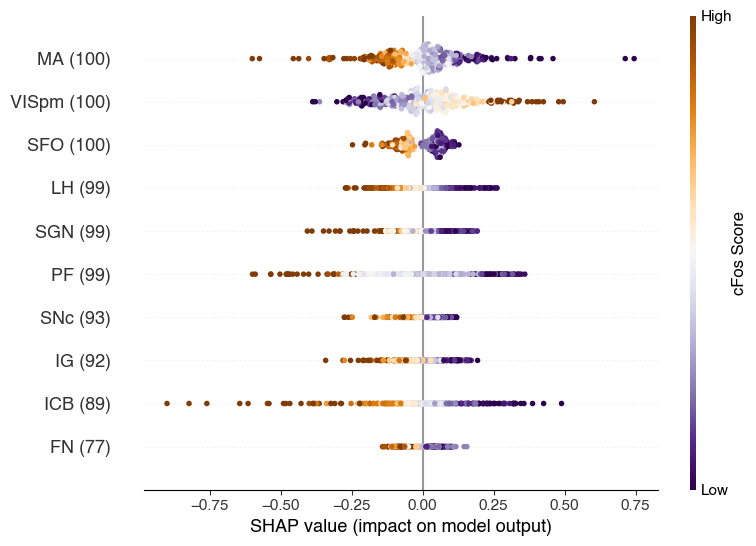

Real: 0.91 accuracy with a standard deviation of 0.16


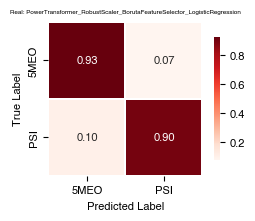

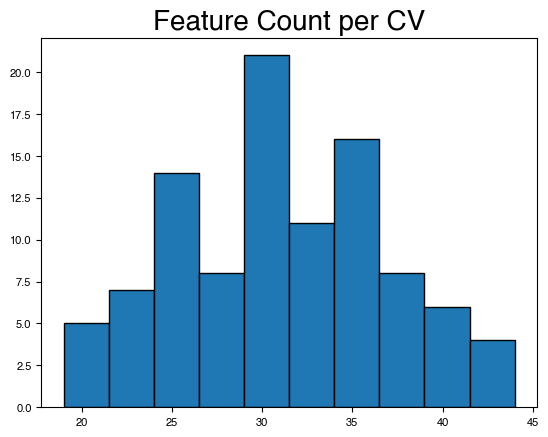

==== 5MEO vs PSI ==== 
 Features per Model: [25, 21, 41, 26, 36, 29, 30, 37, 22, 28, 19, 38, 35, 36, 37, 35, 25, 43, 29, 22, 34, 28, 29, 26, 38, 37, 25, 27, 30, 34, 36, 22, 32, 25, 34, 30, 37, 34, 25, 30, 31, 35, 44, 32, 35, 23, 31, 29, 30, 28, 25, 20, 33, 29, 31, 22, 26, 37, 44, 26, 26, 33, 31, 28, 30, 40, 23, 28, 31, 35, 41, 21, 32, 30, 30, 26, 28, 32, 41, 43, 39, 32, 27, 35, 30, 30, 29, 22, 33, 33, 38, 40, 35, 35, 25, 26, 32, 34, 19, 33]
Parameters: 
 
Total Regions = 158 
 Present 1x: 19 - LP, RCH, LC, EW, TMd, VMH, ARH, EPv, MOs, CENT, PYR, NLL, DT, ENTl, PR, POST, NB, CA2, GU
Present 2x: 27 - PCG, IF, AAA, RPA, SPVO, VISp, VISpor, VISpl, DR, CLA, AIp, ISN, AUDpo, ProS, PVH, PS, DN, RL, SCH, NI, BAC, SubG, RH, Xi, MPO, DMX, PG
Present 3x: 12 - ORBvl, VPL, ORBl, PAR, PGRNd, RM, RO, AUDp, PIL, PP, ACB, BLA
Present 4x: 6 - RT, AVPV, IPN, VII, PVa, SSp-n
Present 5x: 5 - SLC, MARN, SIM, IAD, SSp-un
Present 6x: 1 - SPFp
Present 7x: 8 - SG, AM, AT, IV, MT, PVi, PRE, PDTg
Present 8x: 8 - 

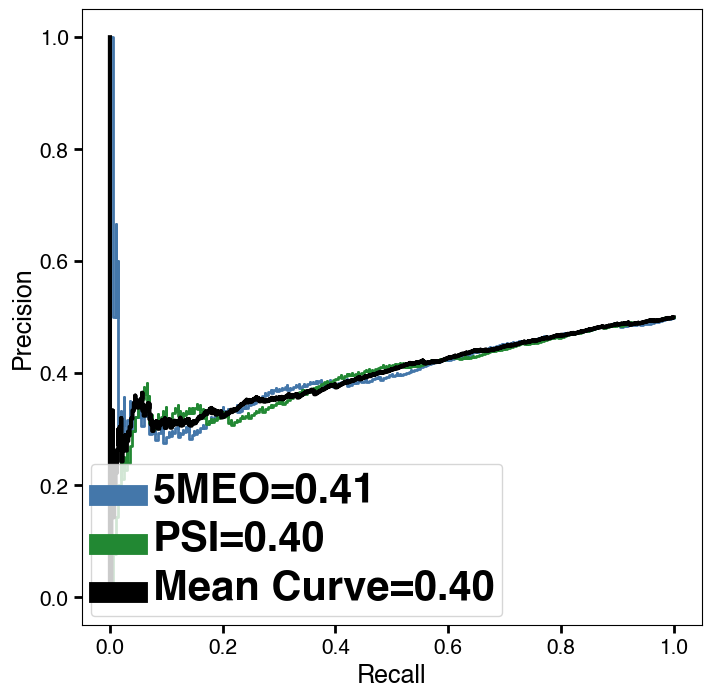

Shuffle: 0.36 accuracy with a standard deviation of 0.19


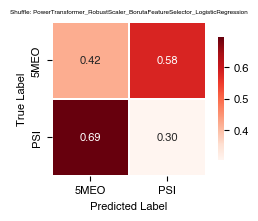

Classifying class_5HT2A
loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


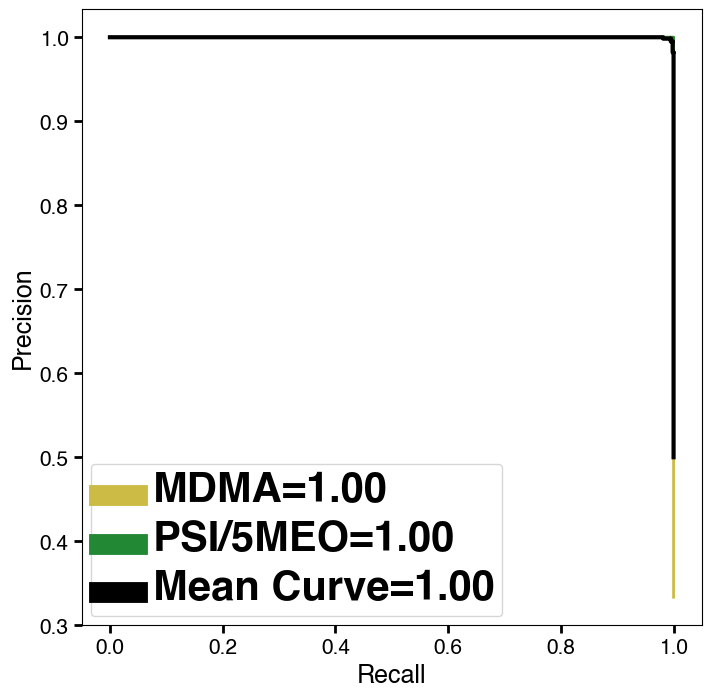

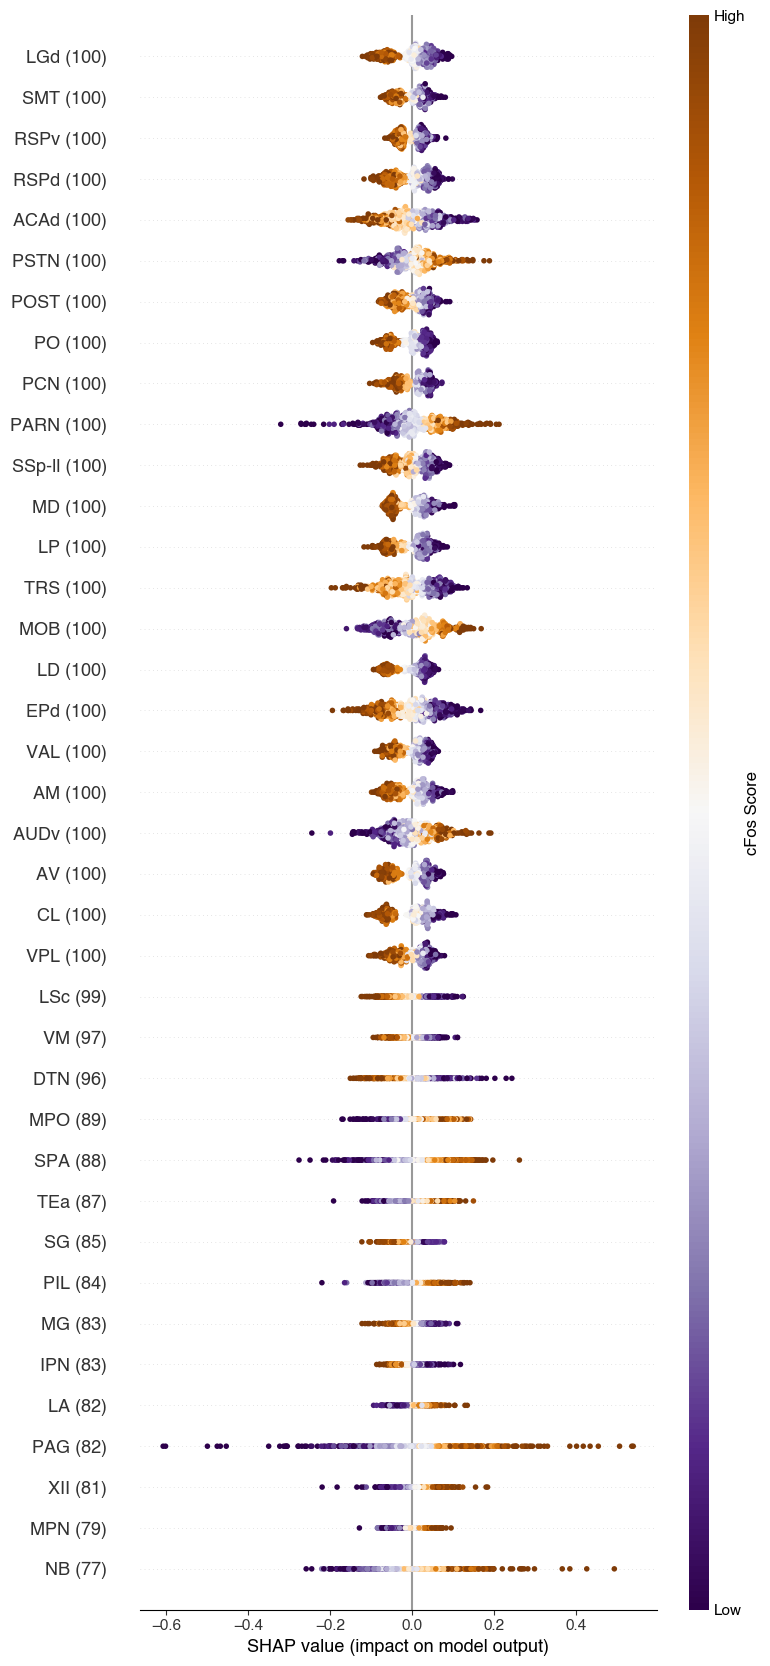

Real: 1.00 accuracy with a standard deviation of 0.03


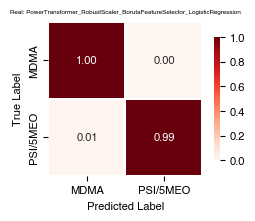

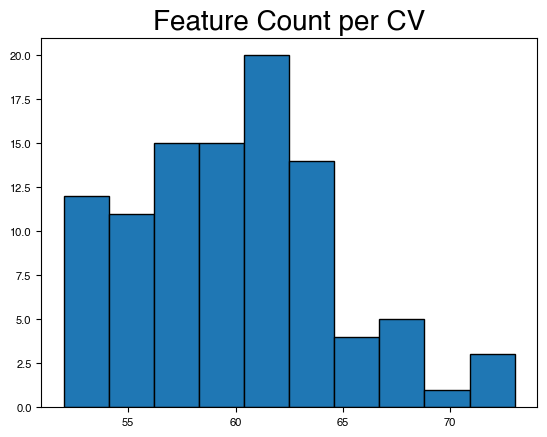

==== MDMA vs PSI/5MEO ==== 
 Features per Model: [55, 57, 59, 61, 61, 59, 61, 63, 63, 71, 56, 54, 64, 61, 61, 62, 53, 67, 62, 55, 54, 60, 53, 62, 71, 63, 73, 63, 52, 62, 62, 64, 53, 62, 64, 58, 58, 63, 61, 60, 54, 62, 59, 60, 57, 58, 63, 62, 55, 58, 62, 60, 65, 56, 55, 58, 57, 58, 58, 64, 62, 67, 57, 68, 53, 54, 68, 59, 59, 53, 60, 60, 62, 57, 65, 63, 58, 63, 65, 69, 56, 62, 64, 65, 56, 61, 57, 58, 55, 55, 54, 53, 67, 60, 59, 63, 59, 61, 55, 59]
Parameters: 
 
Total Regions = 170 
 Present 1x: 21 - BLA, AVPV, DP, PL, GPi, SUM, PAS, AIp, PAA, Pa4, CM, RH, PGRNl, RCH, SCH, TU, VISp, CENT, TMd, BMA, LT
Present 2x: 11 - AD, VISrl, VTN, IG, AP, VeCB, PeF, PAR, IAD, ASO, MRN
Present 3x: 7 - LIN, SCm, AUDd, PRE, CU, CEA, SPIV
Present 4x: 7 - IMD, MT, PRP, VTA, ISN, PVp, PF
Present 5x: 5 - LPO, PS, PRM, PPN, SSs
Present 6x: 8 - CS, IO, NI, VCO, SSp-n, FRP, SPVI, ACVII
Present 7x: 2 - IA, MA3
Present 8x: 2 - RSPagl, LDT
Present 9x: 1 - y
Present 10x: 5 - CA1, DT, PVT, RR, AMB
Present 11x: 3 - F

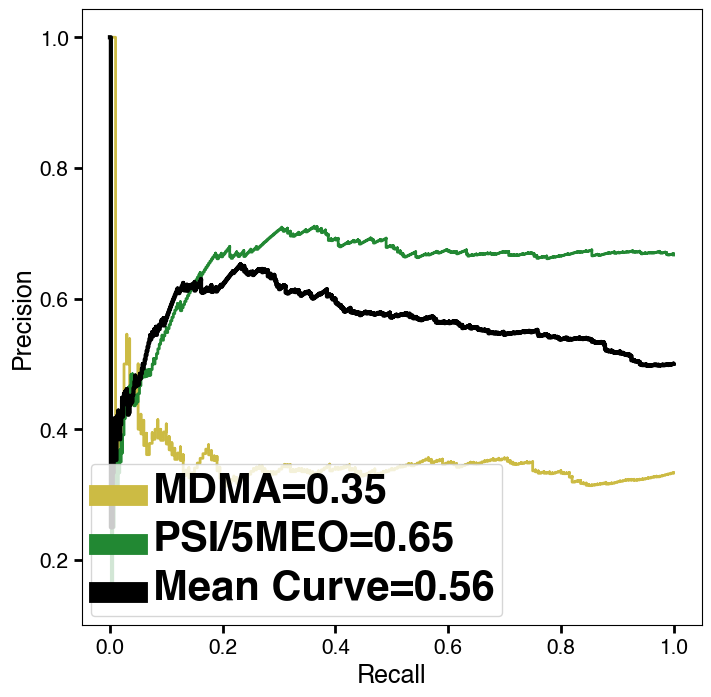

Shuffle: 0.51 accuracy with a standard deviation of 0.16


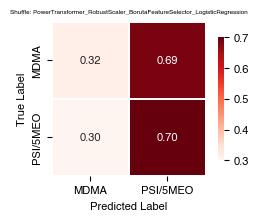

Classifying class_5HTR
loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


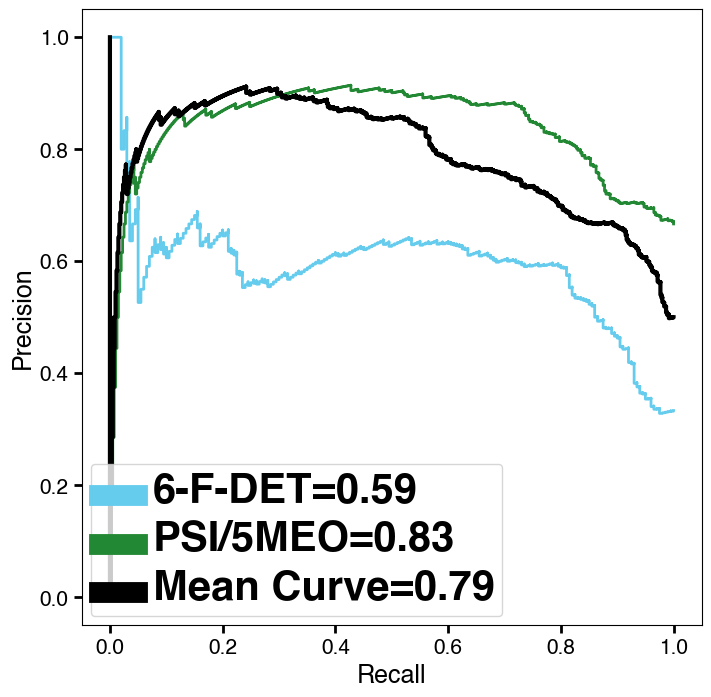

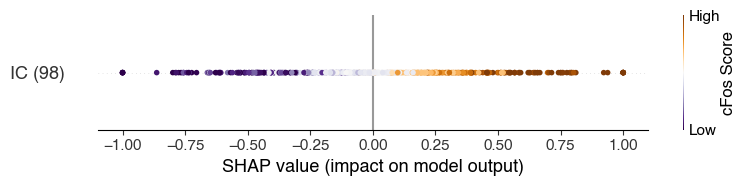

Real: 0.68 accuracy with a standard deviation of 0.19


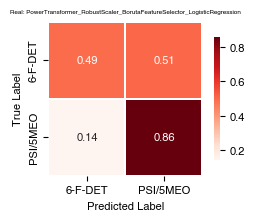

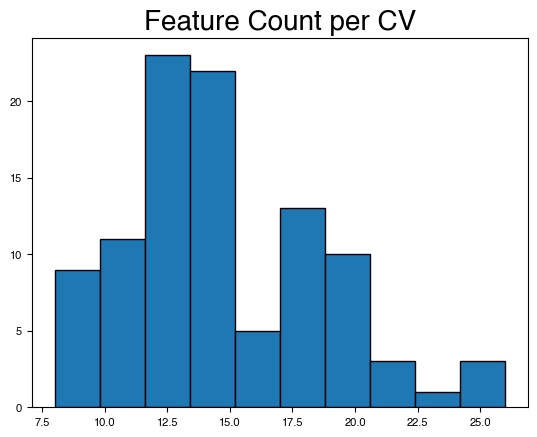

==== 6-F-DET vs PSI/5MEO ==== 
 Features per Model: [11, 10, 12, 15, 21, 18, 25, 19, 19, 18, 16, 13, 14, 13, 13, 15, 11, 16, 14, 14, 13, 15, 11, 20, 19, 15, 17, 15, 20, 14, 13, 16, 12, 8, 12, 13, 9, 12, 14, 12, 18, 14, 17, 9, 17, 16, 19, 15, 13, 15, 12, 15, 13, 21, 18, 13, 10, 9, 14, 13, 9, 13, 19, 19, 18, 11, 9, 14, 16, 13, 13, 9, 17, 18, 12, 14, 11, 18, 26, 20, 14, 10, 20, 11, 13, 8, 15, 15, 17, 17, 12, 15, 11, 21, 26, 14, 13, 9, 11, 24]
Parameters: 
 
Total Regions = 116 
 Present 1x: 32 - CA2, LRN, PR, SSp-tr, IF, VISli, MOs, NOD, PFL, SBPV, MD, PVT, Pa5, AV, SFO, GPi, VMPO, ENTl, POL, SPA, LPO, SMT, ACAv, LSv, PERI, VISpl, BA, VI, x, VeCB, PPY, PGRNl
Present 2x: 13 - APr, SPIV, PRE, MS, MT, PG, PoT, MEPO, MOB, RR, III, FL, AUDd
Present 3x: 10 - ICB, RL, LM, DTN, AHN, FC, PS, LSc, RO, SSp-m
Present 4x: 9 - SSs, PVH, PYR, VII, Xi, PVHd, IAD, PRNc, DMX
Present 5x: 3 - UVU, SCm, NR
Present 6x: 2 - RSPd, SI
Present 7x: 2 - SSp-ul, VLPO
Present 8x: 4 - POST, PAG, CUN, TRS
Present 9x: 1 

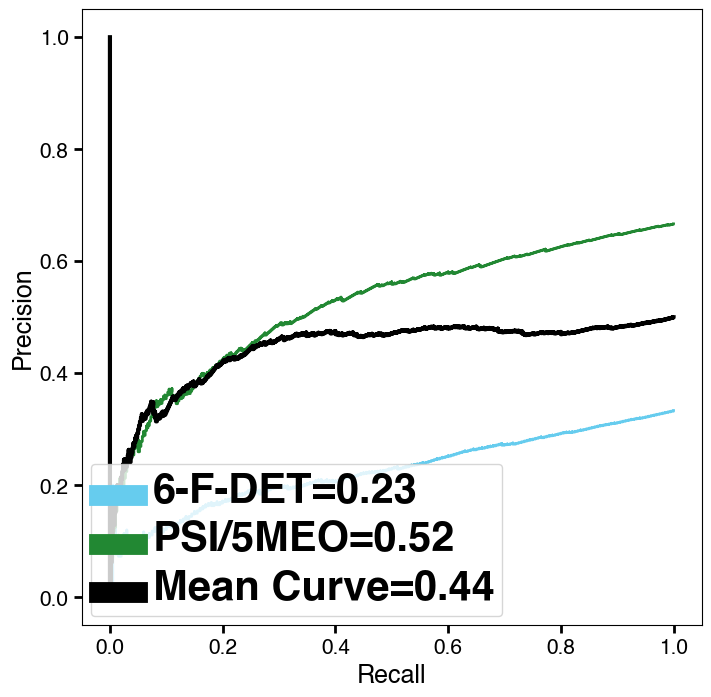

Shuffle: 0.37 accuracy with a standard deviation of 0.15


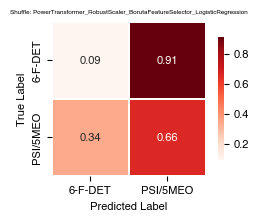

Classifying class_PsiMDMA
loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


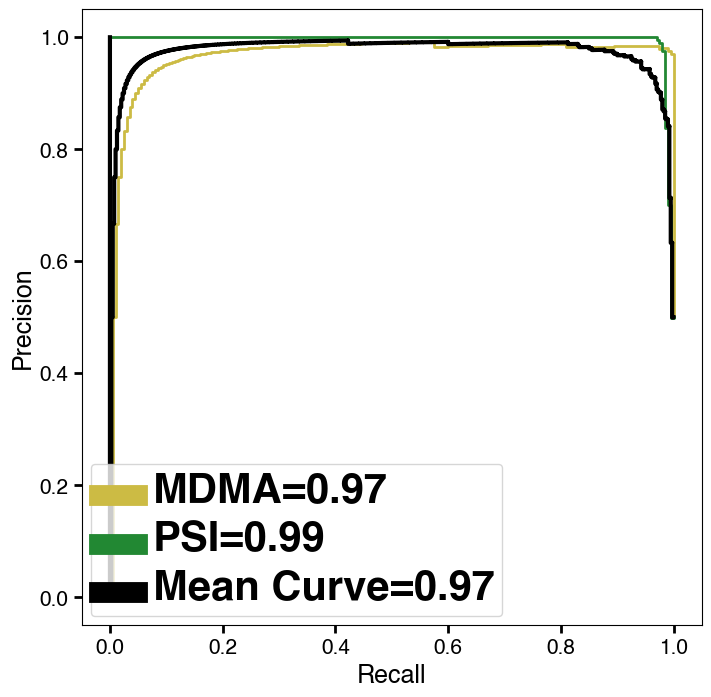

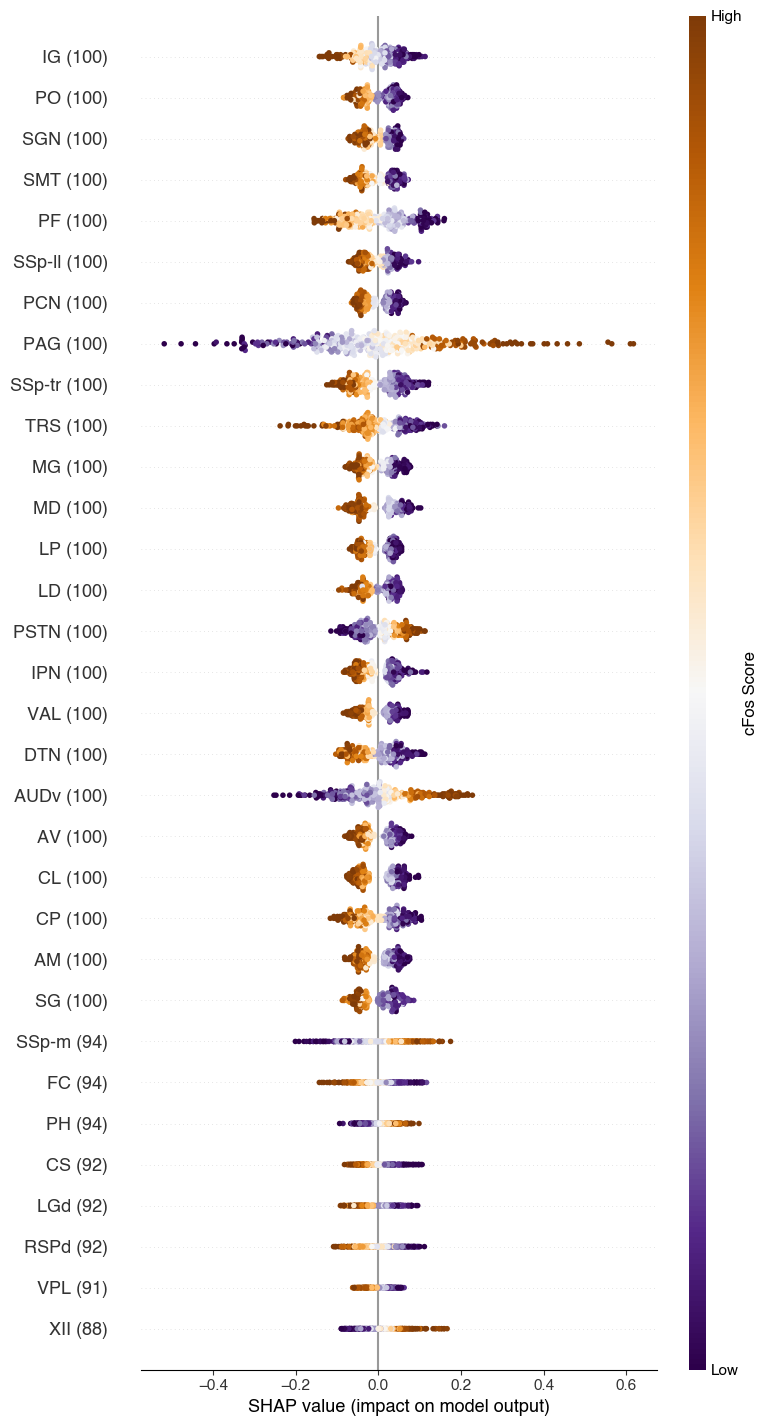

Real: 0.94 accuracy with a standard deviation of 0.10


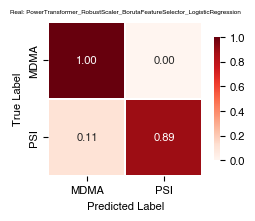

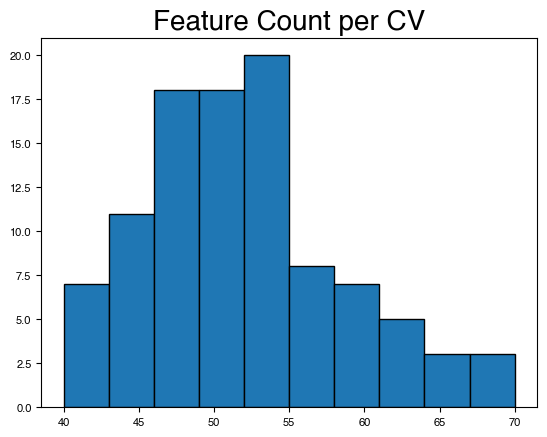

==== MDMA vs PSI ==== 
 Features per Model: [48, 55, 43, 40, 48, 51, 44, 58, 50, 49, 45, 54, 60, 49, 66, 54, 42, 46, 42, 65, 47, 51, 44, 52, 47, 44, 51, 43, 52, 46, 46, 60, 57, 51, 47, 53, 67, 53, 57, 60, 52, 57, 40, 52, 62, 49, 70, 49, 66, 49, 47, 54, 60, 40, 45, 44, 47, 48, 46, 56, 48, 48, 62, 50, 48, 54, 54, 49, 43, 42, 50, 70, 51, 53, 57, 50, 42, 58, 50, 47, 63, 57, 54, 52, 53, 54, 53, 59, 52, 54, 49, 45, 52, 47, 56, 61, 62, 51, 48, 44]
Parameters: 
 
Total Regions = 167 
 Present 1x: 14 - NDB, FOTU, SLD, ACAv, IMD, LC, LDT, PCG, VISpor, LIN, PR, SCs, MEA, EW
Present 2x: 10 - COPY, AId, RT, EPv, MA, VTA, MARN, Acs5, PYR, GPi
Present 3x: 19 - AP, I5, DP, SIM, IF, MDRNd, VI, VISrl, VCO, FRP, PeF, SCm, PSV, y, ACB, ORBl, RR, UVU, PD
Present 4x: 7 - PRM, SSp-bfd, CENT, CA1, ADP, ASO, LA
Present 5x: 9 - PBG, AUDd, DMX, NTB, GPe, GU, PMv, SFO, SUB
Present 6x: 2 - TRN, APr
Present 7x: 2 - AT, Pa5
Present 8x: 6 - PIL, SSp-un, RN, LH, CA2, P5
Present 9x: 1 - BST
Present 10x: 2 - AUDpo, AIp


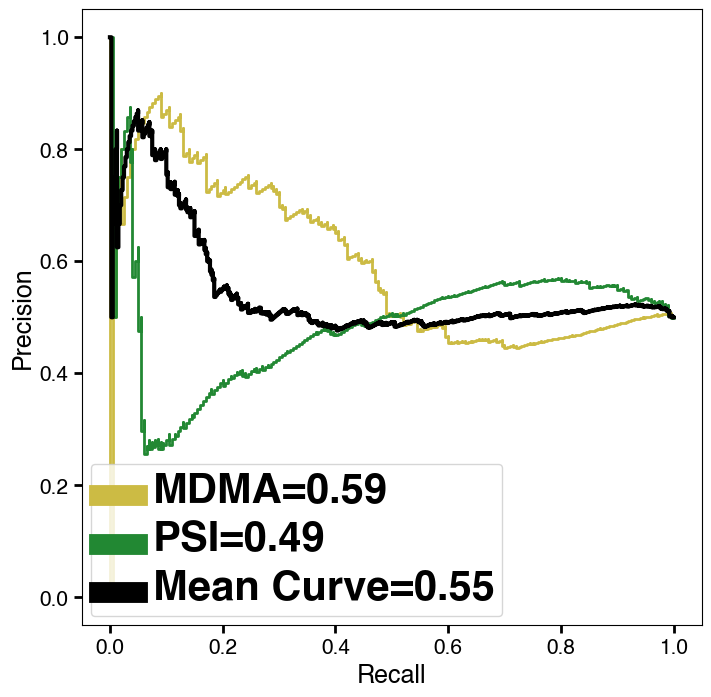

Shuffle: 0.49 accuracy with a standard deviation of 0.18


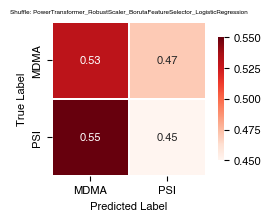

Classifying class_SSRI
loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


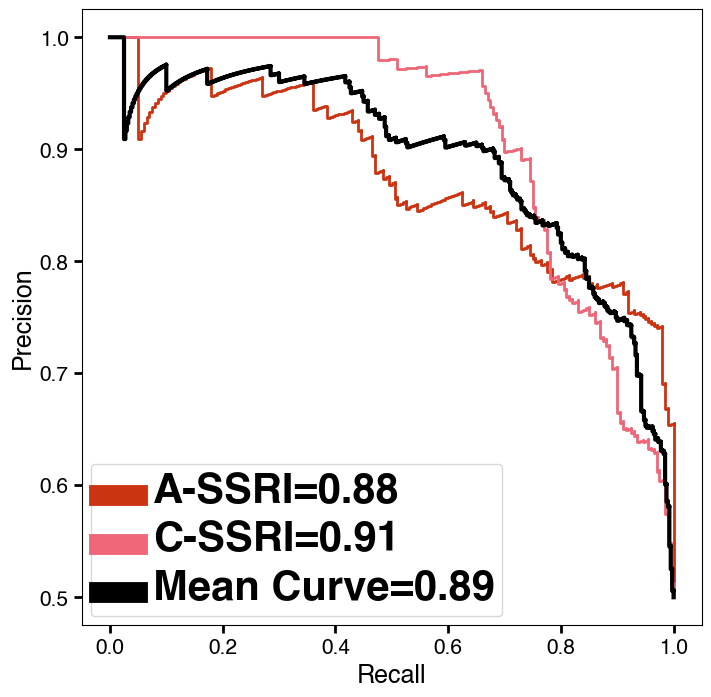

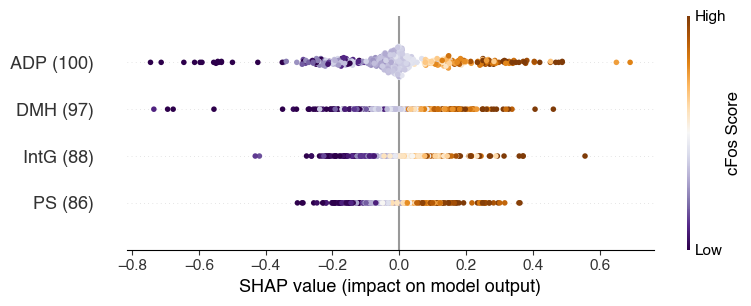

Real: 0.81 accuracy with a standard deviation of 0.21


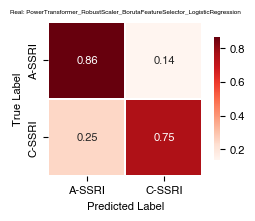

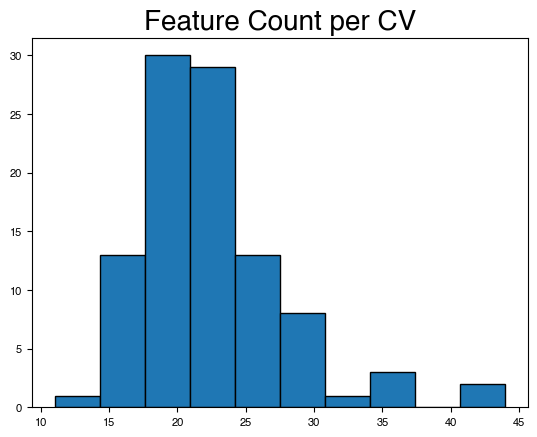

==== A-SSRI vs C-SSRI ==== 
 Features per Model: [25, 36, 27, 25, 22, 19, 24, 21, 24, 24, 15, 11, 22, 19, 16, 24, 20, 16, 27, 19, 30, 27, 18, 18, 27, 21, 19, 19, 22, 22, 20, 15, 22, 19, 21, 26, 25, 27, 21, 24, 35, 17, 18, 28, 28, 21, 19, 20, 18, 21, 21, 22, 43, 29, 16, 22, 35, 18, 17, 21, 19, 19, 23, 20, 15, 19, 20, 17, 24, 31, 20, 23, 20, 21, 19, 27, 18, 20, 23, 26, 17, 24, 28, 30, 22, 29, 17, 20, 19, 44, 20, 30, 27, 22, 23, 25, 20, 20, 17, 17]
Parameters: 
 
Total Regions = 135 
 Present 1x: 27 - Acs5, P5, SAG, CLA, VISpm, NPC, LIN, PARN, PAR, RO, AT, AOB, BAC, PoT, SPA, MA, BLA, LA, PPN, ACB, VISa, IP, AN, FC, SH, CM, ARH
Present 2x: 8 - MOp, PC5, VTN, TR, SPVO, PVi, AVPV, STN
Present 3x: 5 - OV, TEa, III, RL, PSTN
Present 4x: 15 - AV, LM, LP, PR, MH, SSs, MEV, LSr, AIp, CU, MPN, VISp, VPLpc, IPN, AId
Present 5x: 3 - PeF, ZI, IMD
Present 6x: 3 - LGd, XII, I5
Present 7x: 3 - RT, NLOT, GU
Present 8x: 2 - MEPO, MS
Present 9x: 4 - FS, PRNr, Pa4, SBPV
Present 10x: 5 - FOTU, MDRNv, RSPd, 

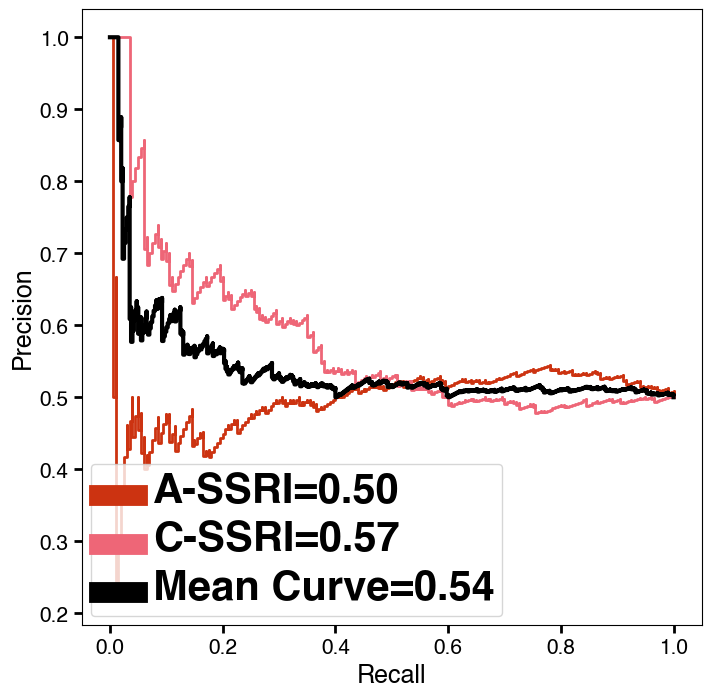

Shuffle: 0.52 accuracy with a standard deviation of 0.19


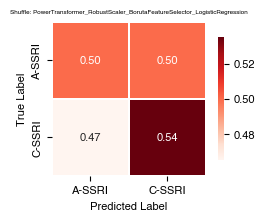

Classifying class_PsiDF
loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


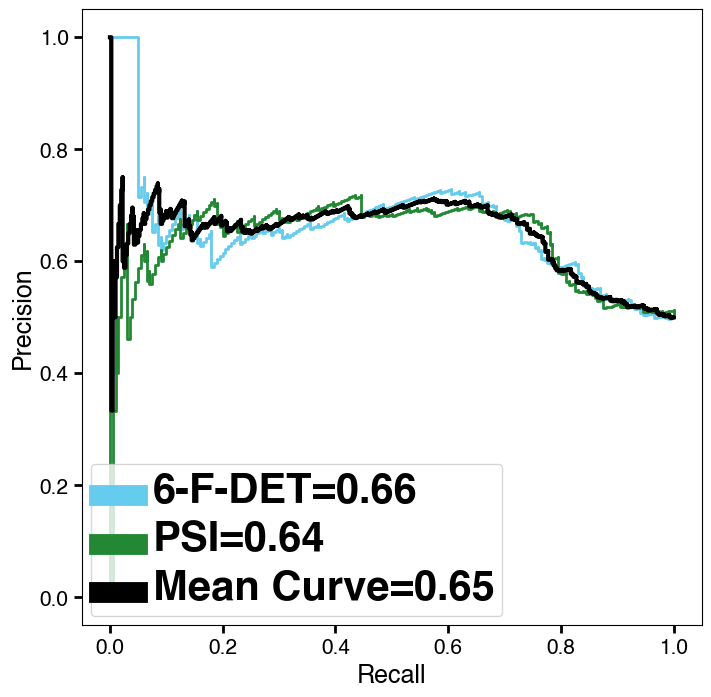

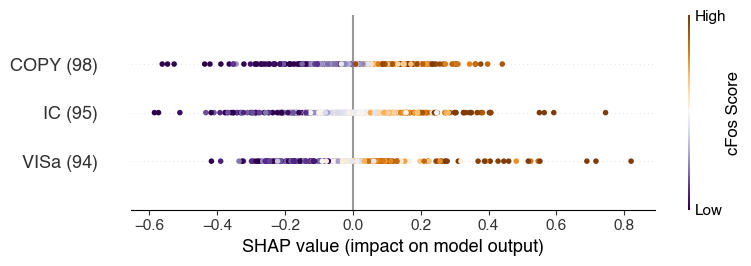

Real: 0.69 accuracy with a standard deviation of 0.19


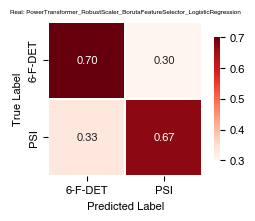

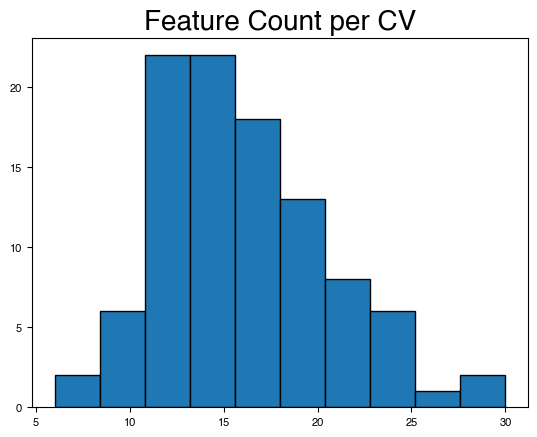

==== 6-F-DET vs PSI ==== 
 Features per Model: [19, 25, 18, 9, 12, 11, 11, 12, 14, 9, 15, 16, 16, 16, 17, 13, 16, 15, 19, 12, 20, 13, 18, 12, 10, 14, 15, 14, 12, 16, 17, 16, 18, 22, 15, 12, 14, 27, 14, 22, 17, 19, 17, 28, 6, 22, 12, 23, 11, 17, 13, 13, 13, 19, 15, 11, 6, 16, 15, 22, 10, 14, 14, 18, 11, 21, 19, 25, 13, 13, 9, 16, 13, 16, 17, 16, 19, 16, 19, 23, 15, 15, 15, 30, 15, 9, 15, 21, 16, 22, 11, 14, 19, 21, 14, 23, 14, 15, 24, 11]
Parameters: 
 
Total Regions = 129 
 Present 1x: 32 - MDRNv, PDTg, FN, LHA, CA3, SUB, AHN, AP, DN, ACVII, NLOT, PARN, CLA, VI, AUDpo, FL, OT, IPN, APN, AT, PS, PGRNd, NLL, NI, SLC, VAL, VLPO, OP, BLA, AIv, RR, CLI
Present 2x: 13 - LRN, MS, PD, ACAv, SGN, MARN, SCs, VISal, CEA, x, VTN, IRN, GPe
Present 3x: 12 - LM, LING, SSs, AUDd, SSp-m, VII, PP, LA, CUL, ISN, VISl, PVa
Present 4x: 12 - MOB, Acs5, I5, OV, POST, Pa4, UVU, VISp, ZI, VPL, MA, SSp-bfd
Present 5x: 5 - VISam, MPN, VISC, PVT, SMT
Present 6x: 2 - MDRN, NTS
Present 7x: 4 - IG, NDB, NR, RSPagl
P

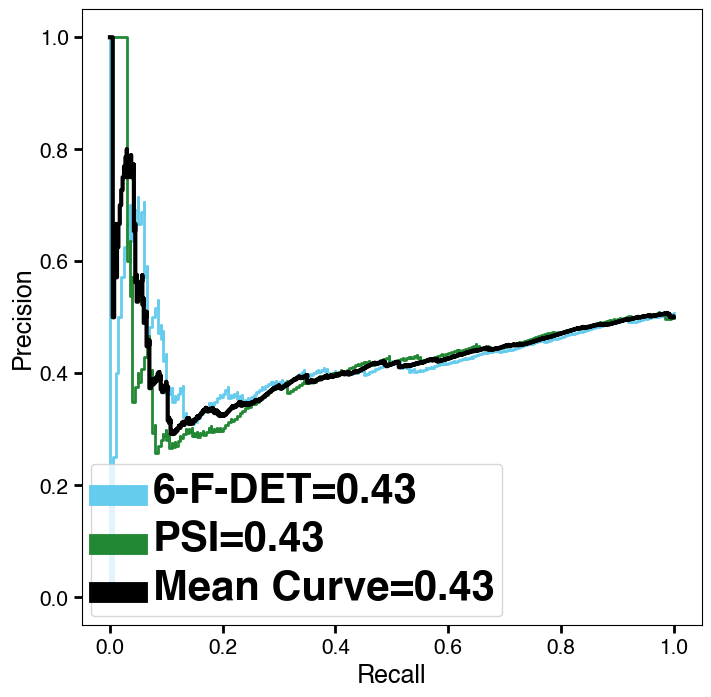

Shuffle: 0.40 accuracy with a standard deviation of 0.19


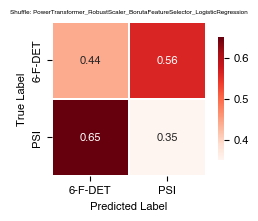

Classifying class_PsiSSRI
loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


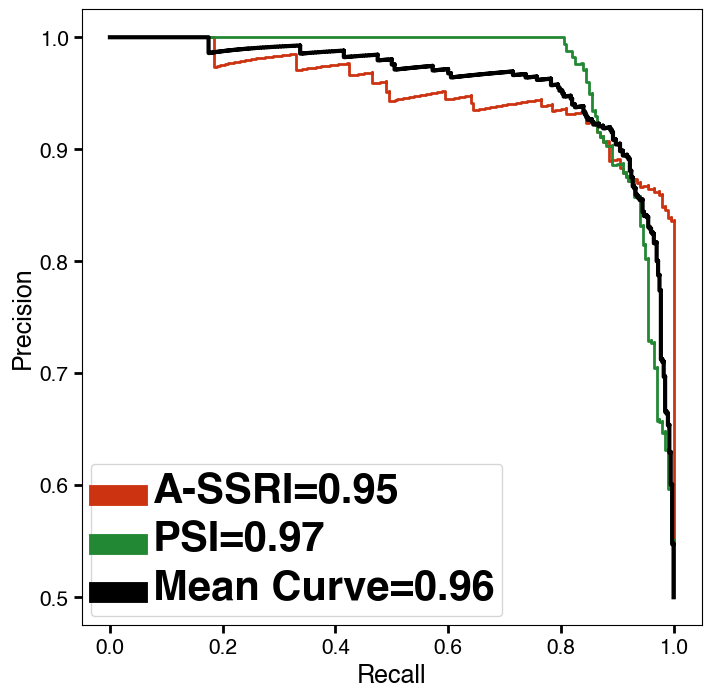

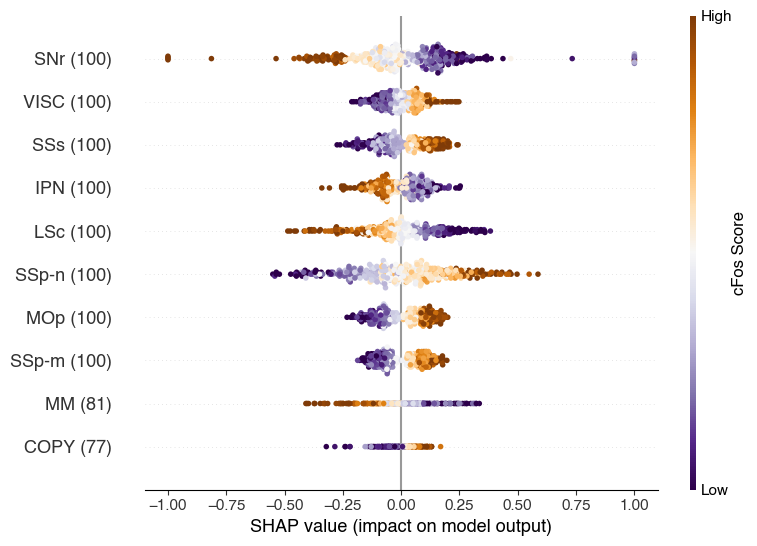

Real: 0.91 accuracy with a standard deviation of 0.13


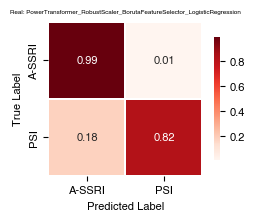

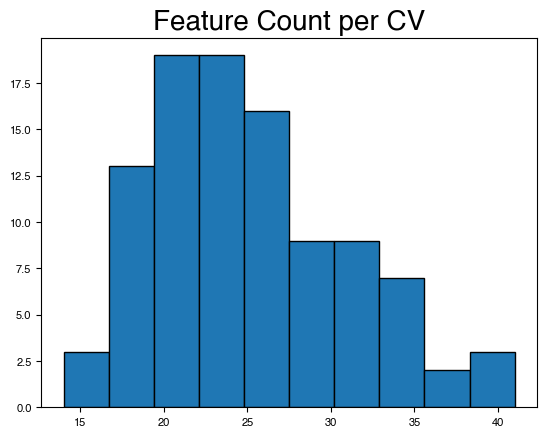

==== A-SSRI vs PSI ==== 
 Features per Model: [18, 21, 21, 19, 24, 24, 23, 27, 18, 19, 19, 23, 23, 30, 23, 34, 22, 31, 34, 17, 27, 35, 32, 20, 21, 22, 22, 22, 30, 38, 31, 22, 19, 23, 23, 21, 22, 28, 27, 30, 30, 33, 26, 22, 28, 23, 25, 17, 27, 31, 24, 32, 30, 22, 18, 19, 23, 41, 24, 19, 26, 32, 20, 23, 41, 22, 22, 40, 26, 35, 21, 27, 22, 14, 33, 23, 26, 20, 23, 32, 31, 26, 31, 24, 26, 26, 19, 17, 37, 23, 29, 29, 25, 27, 33, 23, 16, 26, 24, 16]
Parameters: 
 
Total Regions = 152 
 Present 1x: 34 - MDRNv, FS, POST, PRE, SCO, ORBl, MOB, NOD, NTB, LGv, POL, VM, VAL, SSp-bfd, SSp-un, LDT, MEV, OP, SIM, TEa, VPLpc, PL, LIN, AAA, IA, LHA, AD, PVpo, LA, GR, VCO, VISal, PeF, PA
Present 2x: 18 - IV, UVU, ENTm, LD, MARN, VPM, SPIV, EPd, PSTN, AT, LH, PPT, AON, V, IGL, TT, OT, VISpl
Present 3x: 6 - SubG, STN, SFO, SUM, AHN, LM
Present 4x: 6 - SCH, ARH, AN, MDRN, LPO, RO
Present 5x: 7 - PVH, PMd, CU, CUL, MRN, FRP, NLOT
Present 6x: 4 - NR, DEC, VTN, RE
Present 7x: 6 - APr, PRM, SLC, AOB, PYR, MS
Pre

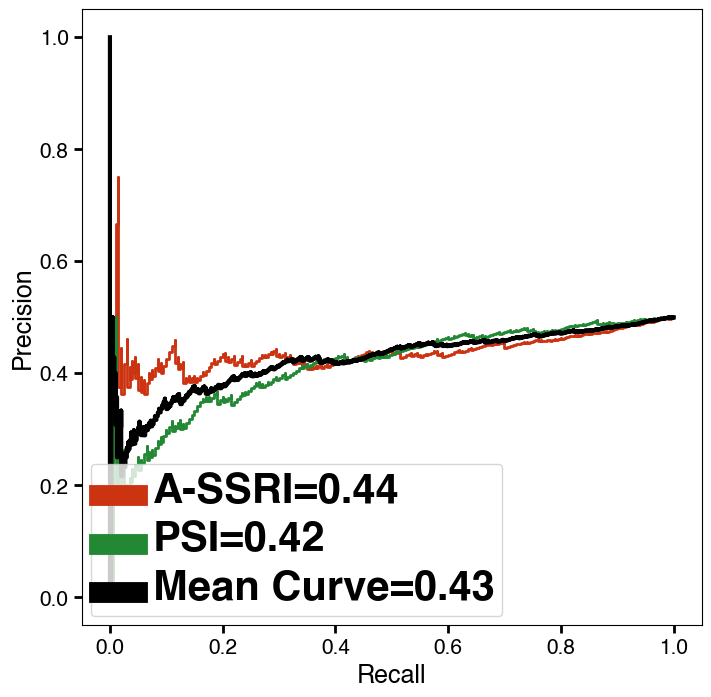

Shuffle: 0.42 accuracy with a standard deviation of 0.22


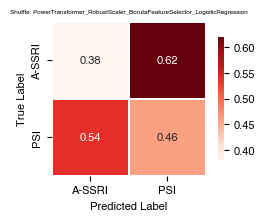

Classifying class_PsiKet
loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


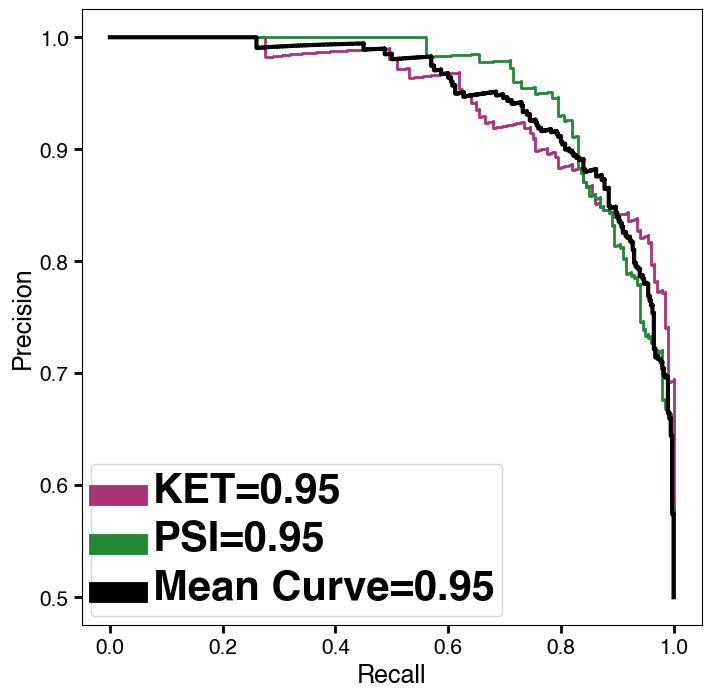

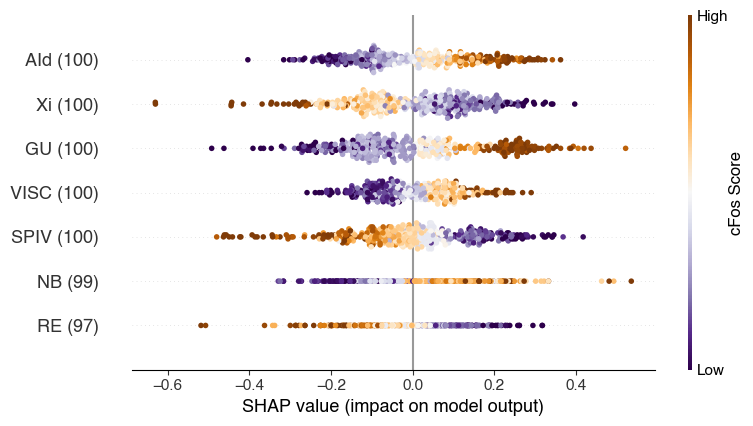

Real: 0.87 accuracy with a standard deviation of 0.17


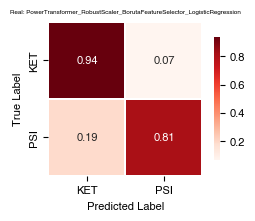

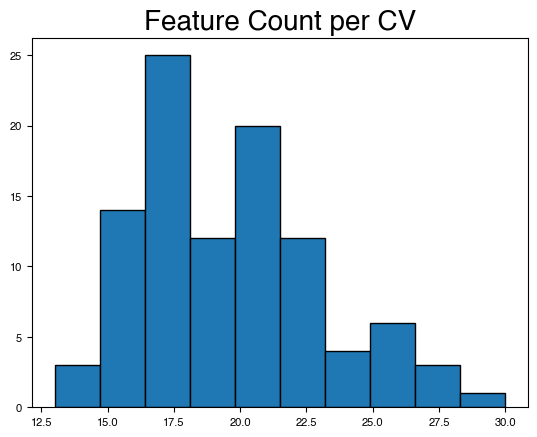

==== KET vs PSI ==== 
 Features per Model: [26, 19, 16, 19, 24, 28, 14, 18, 19, 20, 19, 24, 16, 18, 25, 25, 16, 21, 17, 15, 22, 27, 18, 21, 25, 25, 18, 16, 21, 17, 22, 23, 18, 21, 19, 18, 16, 19, 30, 18, 23, 15, 18, 21, 24, 23, 17, 19, 20, 20, 18, 18, 18, 18, 23, 20, 23, 16, 20, 15, 17, 24, 22, 21, 15, 23, 19, 17, 20, 19, 18, 20, 16, 19, 21, 27, 18, 16, 23, 16, 13, 20, 19, 17, 18, 17, 23, 16, 19, 26, 17, 18, 20, 17, 23, 20, 21, 20, 13, 21]
Parameters: 
 
Total Regions = 109 
 Present 1x: 13 - ASO, AAA, VISli, ECU, PAG, PMd, FC, IPN, Pa4, SI, IRN, RL, VeCB
Present 2x: 11 - BST, VI, VISpl, SLD, CUN, LAV, UVU, MOs, III, AVP, COAp
Present 3x: 10 - LA, NTB, CA1, LSr, PD, DP, SPA, AUDv, IA, RCH
Present 4x: 3 - AIp, MDRNv, MS
Present 5x: 3 - PDTg, MDRN, MEPO
Present 6x: 4 - CEA, PCG, COPY, PPY
Present 7x: 4 - BLA, AUDpo, IMD, PeF
Present 8x: 6 - CL, ADP, RPO, GPi, PL, PIR
Present 9x: 2 - SNc, GRN
Present 10x: 4 - PS, HATA, Acs5, MPO
Present 11x: 2 - MDRNd, ARH
Present 12x: 3 - PA, SG, NLOT
Pr

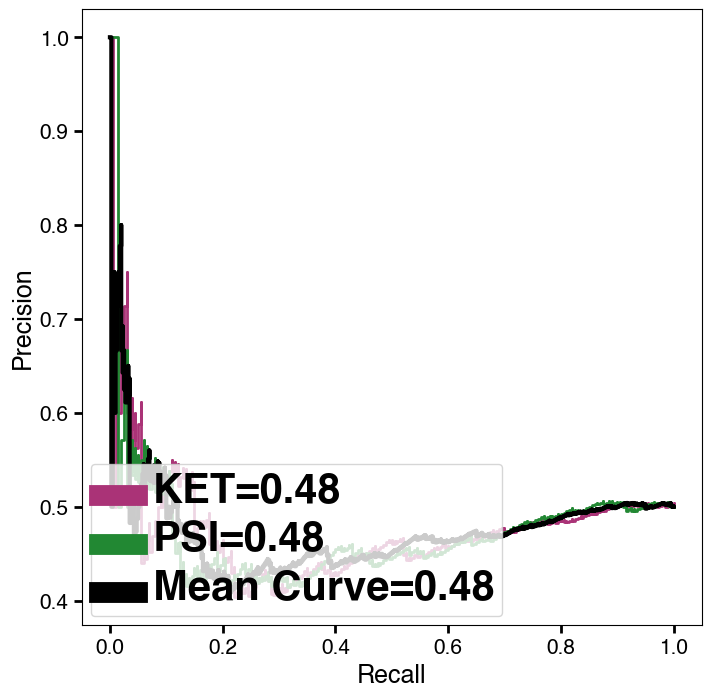

Shuffle: 0.45 accuracy with a standard deviation of 0.23


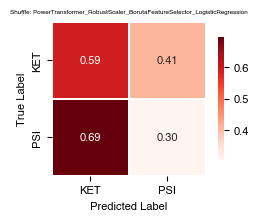

Classifying class_DT
loading model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')


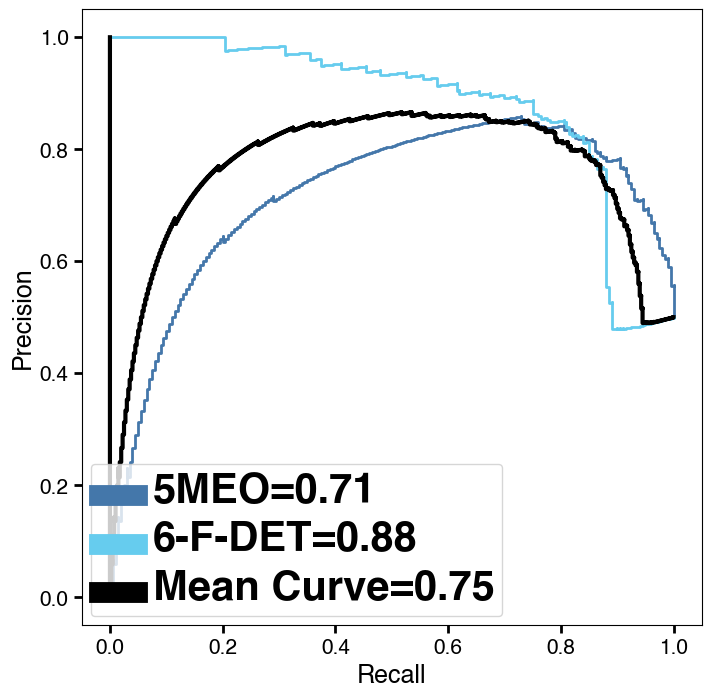

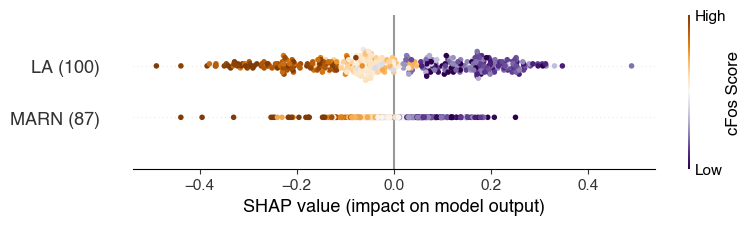

Real: 0.81 accuracy with a standard deviation of 0.18


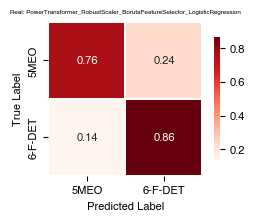

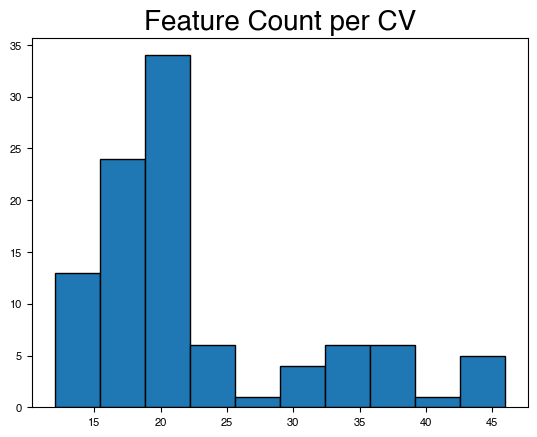

==== 5MEO vs 6-F-DET ==== 
 Features per Model: [20, 18, 39, 37, 21, 25, 22, 28, 22, 14, 17, 31, 22, 15, 17, 19, 14, 22, 44, 43, 15, 24, 15, 23, 22, 17, 18, 30, 18, 20, 18, 19, 22, 43, 13, 17, 37, 20, 34, 21, 14, 35, 20, 30, 19, 15, 19, 17, 16, 17, 20, 13, 36, 19, 35, 35, 16, 12, 19, 17, 24, 14, 18, 23, 18, 20, 16, 16, 20, 33, 19, 16, 46, 37, 22, 21, 40, 21, 24, 19, 17, 17, 17, 20, 21, 43, 18, 21, 19, 30, 13, 18, 21, 20, 17, 13, 20, 33, 19, 39]
Parameters: 
 
Total Regions = 146 
 Present 1x: 27 - PR, PBG, AOB, SCH, SCm, PSTN, SLC, SLD, IF, PGRNd, CLI, NLL, BLA, ECT, LP, MOB, PVp, VPM, PPY, CU, PT, PVa, LDT, BA, MDRNv, AUDd, VTN
Present 2x: 14 - AHN, CM, RH, PFL, LPO, PAR, MT, x, SO, VTA, MA3, AIp, VeCB, AAA
Present 3x: 8 - ACAv, SubG, OT, CUN, SPIV, SFO, SPA, CUL
Present 4x: 4 - PVi, SPFm, VISl, VISpor
Present 5x: 8 - TMv, AN, DEC, RPA, MA, SUV, IV, IP
Present 6x: 4 - UVU, ASO, MV, IMD
Present 7x: 5 - ENTl, Pa4, PS, RSPagl, AVPV
Present 8x: 5 - ENTm, PYR, VMPO, MRN, CENT
Present 9x: 7

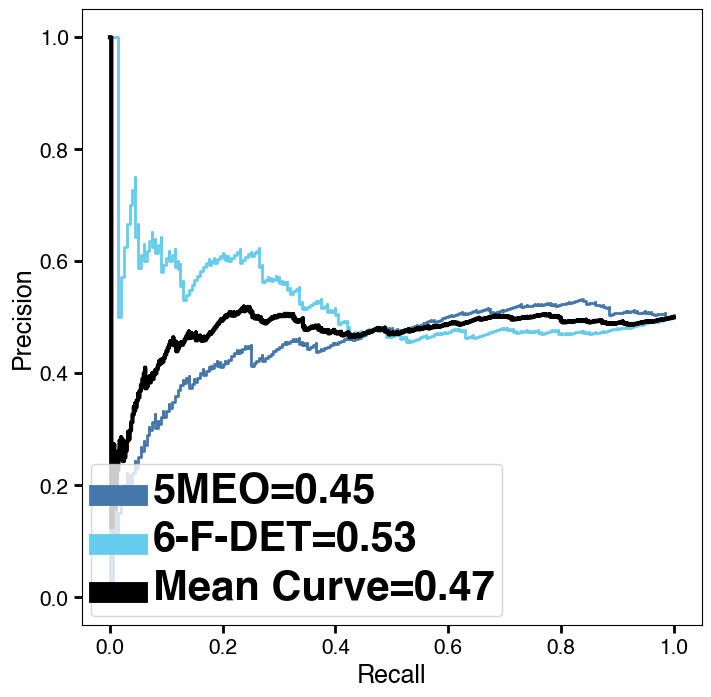

Shuffle: 0.48 accuracy with a standard deviation of 0.18


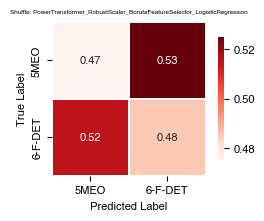

In [7]:
classifyVec = ['class_PsiDMT', 'class_5HT2A', 'class_5HTR', 'class_PsiMDMA', 'class_SSRI', 'class_PsiDF', 'class_PsiSSRI', 'class_PsiKet', 'class_DT']

for i in classifyVec:
    try:
        print(f"Classifying {i}")
        classifyDict['label'] = i
        classifyFunctions.classifySamples(lightsheet_data, classifyDict, plotDict, dirDict)
    except Exception:
      print(f"\n Failed to classify {i}")